<a href="https://colab.research.google.com/github/hmzakt/Mask-detection-model/blob/main/face_mask_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FACE-MASK DETECTION MODEL

In [1]:
# from google.colab import files
# files.upload()

In [2]:
# Create kaggle directory and move the key
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# Install Kaggle CLI if not already
!pip install -q kaggle

# Download dataset (example: face mask detection)
!kaggle datasets download -d andrewmvd/face-mask-detection

# Unzip it
!unzip -q face-mask-detection.zip -d face_mask_data

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/face-mask-detection
License(s): CC0-1.0
face-mask-detection.zip: Skipping, found more recently modified local copy (use --force to force download)
replace face_mask_data/annotations/maksssksksss0.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [4]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import dataloader
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

## Preparing the data

In [5]:
train_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])

])

val_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])

])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
])


In [6]:
import os
import xml.etree.ElementTree as ET
from PIL import Image

# Paths
IMG_DIR = 'face_mask_data/images'
ANN_DIR = 'face_mask_data/annotations'
OUTPUT_DIR = 'data_raw'

# Create output folders
os.makedirs(os.path.join(OUTPUT_DIR, 'with_mask'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, 'without_mask'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, 'mask_worn_incorrectly'), exist_ok=True)

# Parse each annotation
for ann_file in os.listdir(ANN_DIR):
    if not ann_file.endswith('.xml'):
        continue
    tree = ET.parse(os.path.join(ANN_DIR, ann_file))
    root = tree.getroot()

    img_file = root.find('filename').text
    img_path = os.path.join(IMG_DIR, img_file)
    image = Image.open(img_path)

    for i, obj in enumerate(root.findall('object')):
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(float(bbox.find('xmin').text))
        ymin = int(float(bbox.find('ymin').text))
        xmax = int(float(bbox.find('xmax').text))
        ymax = int(float(bbox.find('ymax').text))

        cropped_face = image.crop((xmin, ymin, xmax, ymax))

        # Convert to RGB if the mode is RGBA
        if cropped_face.mode == 'RGBA':
            cropped_face = cropped_face.convert('RGB')

        if label == 'with_mask':
            save_path = os.path.join(OUTPUT_DIR, 'with_mask', f'{ann_file[:-4]}_{i}.jpg')
        elif label == 'without_mask':
            save_path = os.path.join(OUTPUT_DIR, 'without_mask', f'{ann_file[:-4]}_{i}.jpg')
        elif label == 'mask_worn_incorrect':
            save_path = os.path.join(OUTPUT_DIR, 'mask_worn_incorrectly', f'{ann_file[:-4]}_{i}.jpg')
        else:
            continue

        cropped_face.save(save_path)

In [7]:
import os
import shutil
from sklearn.model_selection import train_test_split

SOURCE_DIR = 'data_raw';
DEST_DIR = 'data'

classes = ['with_mask', 'without_mask']

train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

for split in ['train', 'val', 'test']:
  for cls in classes:
        split_path = os.path.join(DEST_DIR, split, cls)
        os.makedirs(split_path, exist_ok=True)

for cls in classes :
  img_dir = os.path.join(SOURCE_DIR, cls)
  all_images = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png'))]

  train_imgs, temp_imgs = train_test_split(all_images, train_size=train_ratio, random_state=42)
  val_imgs, test_imgs = train_test_split(temp_imgs, test_size=test_ratio/(val_ratio + test_ratio), random_state=42)

  os.makedirs(os.path.join(DEST_DIR, 'train', cls), exist_ok=True)
  os.makedirs(os.path.join(DEST_DIR, 'val', cls), exist_ok=True)
  os.makedirs(os.path.join(DEST_DIR, 'test', cls), exist_ok=True)


  for img in train_imgs:
    shutil.copy(os.path.join(img_dir, img), os.path.join(DEST_DIR, 'train', cls, img))

  for img in val_imgs:
    shutil.copy(os.path.join(img_dir, img), os.path.join(DEST_DIR, 'val', cls, img))

  for img in test_imgs:
    shutil.copy(os.path.join(img_dir, img), os.path.join(DEST_DIR, 'test', cls, img))


In [8]:
!find data/ -type d -name ".ipynb_checkpoints" -exec rm -r {} +


In [9]:
# loading the dataset
DEST_DIR = 'data'

train_data = datasets.ImageFolder(root=os.path.join(DEST_DIR, 'train'), transform=train_transform)
val_data   = datasets.ImageFolder(root=os.path.join(DEST_DIR, 'val'), transform=val_transform)
test_data  = datasets.ImageFolder(root=os.path.join(DEST_DIR, 'test'), transform=test_transform)


In [10]:
len(train_data), len(val_data), len(test_data)

(3158, 395, 396)

In [11]:
class_names = train_data.classes
train_data.classes

['with_mask', 'without_mask']

In [12]:
BATCH_SIZE = 32
train_loader = dataloader.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = dataloader.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = dataloader.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [13]:
train_data

Dataset ImageFolder
    Number of datapoints: 3158
    Root location: data/train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

## Visualizing the data

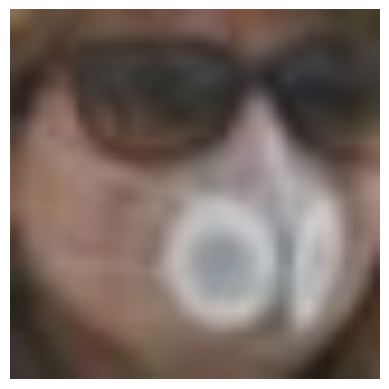

Label: with_mask


In [14]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.show()


images, labels = next(iter(train_loader))
imshow(images[5])
print("Label:", train_data.classes[labels[0]])


## Setting up device agnostic code

In [15]:
device = "cpu"
if torch.cuda.is_available:
  device = "cuda"

device

'cuda'

## Preparing the model

In [16]:
class ResNet18Clone(nn.Module):
  def __init__(self, num_classes = 2):
    super().__init__()

    self.stem = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size = 7, stride =2, padding = 3, bias = False),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size =3, stride =2, padding = 1)
    )

    ## defining out blocks

    self.layer1_block1 = self.block(64,64, stride = 1, downsample = False)
    self.layer1_block2 = self.block(64,64, stride = 1, downsample = False)

    self.layer2_block1 = self.block(64,128, stride = 2, downsample = True)
    self.layer2_block2 = self.block(128,128, stride = 1, downsample = False)

    self.layer3_block1 = self.block(128,256, stride = 2, downsample = True)
    self.layer3_block2 = self.block(256,256, stride = 1,downsample = False)

    self.layer4_block1 = self.block(256,512, stride = 2, downsample = True)
    self.layer4_block2 = self.block(512,512, stride = 1, downsample = False)

    self.avgpool = nn.AdaptiveAvgPool2d((1,1)) #pooling is used to reduce dimensions oposite to interpolation
    self.fc = nn.Linear(512, num_classes)

  def block(self, in_channels, out_channels, stride, downsample):
    layers = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size =3 , stride = stride, padding = 1, bias = False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace = True),
        nn.Conv2d(out_channels, out_channels, kernel_size =3 , stride = 1, padding = 1, bias = False),
        nn.BatchNorm2d(out_channels)
    )

    if downsample:
      down = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = stride, bias = False),
          nn.BatchNorm2d(out_channels)
      )
    else:
      down = nn.Identity()

    return nn.ModuleDict({"layers" : layers, "downsample" : down})

  def forward_block(self, x , block):
    identity = x
    out  = block["layers"](x)
    identity = block["downsample"](identity)

    return nn.ReLU(inplace = True)(out + identity)

  def forward(self, x):
    x = self.stem(x)
    x = self.forward_block(x, self.layer1_block1)
    x = self.forward_block(x, self.layer1_block2)
    x = self.forward_block(x, self.layer2_block1)
    x = self.forward_block(x, self.layer2_block2)
    x = self.forward_block(x, self.layer3_block1)
    x = self.forward_block(x, self.layer3_block2)
    x = self.forward_block(x, self.layer4_block1)
    x = self.forward_block(x, self.layer4_block2)

    x = self.avgpool(x)
    x= torch.flatten(x,1)
    x=self.fc(x)

    return x

In [17]:
def accuracy_fn(y_true, y_pred):
    correct = (y_pred == y_true).sum().item()
    acc = correct / len(y_true) * 100
    return acc

## Writing the training and validation function

In [36]:
model = ResNet18Clone(num_classes=2).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.003)

In [19]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    if(epoch%5 == 0):
      print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def val_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    val_loss, val_acc = 0, 0
    model.to(device)
    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            val_pred = model(X)

            # 2. Calculate loss and accuracy
            val_loss += loss_fn(val_pred, y).item()
            val_acc += accuracy_fn(y_true=y,
                y_pred=val_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        val_loss /= len(data_loader)
        val_acc /= len(data_loader)
        if(epoch%5 == 0):
          print(f"Test loss: {val_loss:.5f} | Test accuracy: {val_acc:.2f}%\n")

## Writing and implementing the training loop

In [41]:
# writing the training loop
epochs = 60 # running two times so total epochs = 120
for epoch in (range(epochs)):
    if(epoch%5 == 0):
      print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_loader,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    val_step(data_loader=val_loader,
        model=model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

Epoch: 0
---------
Train loss: 0.00010 | Train accuracy: 100.00%
Test loss: 0.12250 | Test accuracy: 98.32%

Epoch: 5
---------
Train loss: 0.00008 | Train accuracy: 100.00%
Test loss: 0.12439 | Test accuracy: 98.32%

Epoch: 10
---------
Train loss: 0.00006 | Train accuracy: 100.00%
Test loss: 0.12677 | Test accuracy: 98.32%

Epoch: 15
---------
Train loss: 0.00006 | Train accuracy: 100.00%
Test loss: 0.12949 | Test accuracy: 98.32%

Epoch: 20
---------
Train loss: 0.00005 | Train accuracy: 100.00%
Test loss: 0.15578 | Test accuracy: 97.86%

Epoch: 25
---------
Train loss: 0.00004 | Train accuracy: 100.00%
Test loss: 0.13359 | Test accuracy: 98.32%

Epoch: 30
---------
Train loss: 0.00004 | Train accuracy: 100.00%
Test loss: 0.13681 | Test accuracy: 98.32%

Epoch: 35
---------
Train loss: 0.00003 | Train accuracy: 100.00%
Test loss: 0.13723 | Test accuracy: 98.32%

Epoch: 40
---------
Train loss: 0.00003 | Train accuracy: 100.00%
Test loss: 0.19061 | Test accuracy: 97.86%

Epoch: 45
--

## Evaluating the model

In [52]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the same device as the model
            X, y = X.to(model.parameters().__next__().device), y.to(model.parameters().__next__().device)

            # Make predictions with the model
            y_pred = model(X)

            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

In [53]:
model_results = eval_model(
    model=model,
    data_loader=test_loader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

model_results

{'model_name': 'ResNet18Clone',
 'model_loss': 0.351777046918869,
 'model_acc': 93.34935897435898}

## Plotting the prediction matrix

In [32]:
from tqdm.auto import tqdm

y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_loader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/13 [00:00<?, ?it/s]

In [33]:
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.4


In [34]:
import mlxtend

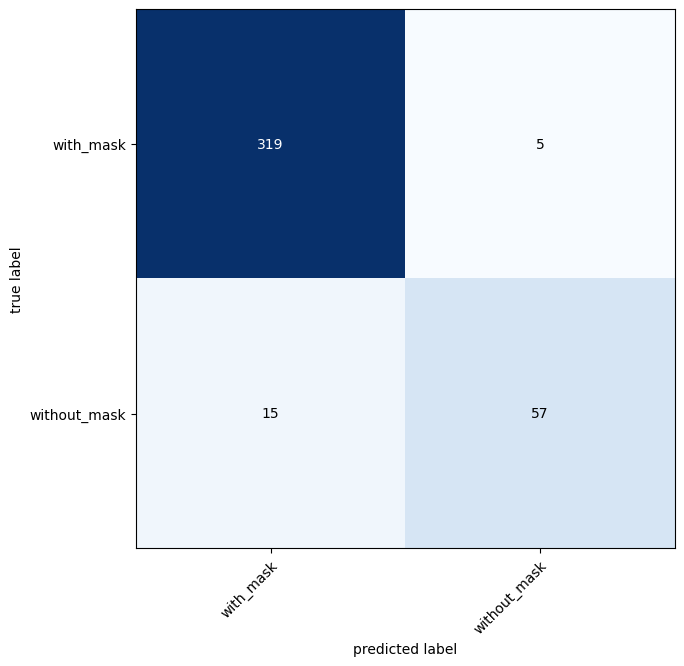

In [35]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
import torch

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=torch.tensor(test_data.targets))

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

## Saving the model

In [42]:
from pathlib import Path


MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True
)

MODEL_NAME = "face_mask_detecton_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/face_mask_detecton_model.pth


## Evaluating the saved model

In [44]:
loaded_model = ResNet18Clone()

# Load in the saved state_dict()
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to GPU
loaded_model = loaded_model.to(device)

In [50]:
# Evaluate loaded model
loaded_model_results = eval_model(
    model=loaded_model,
    data_loader=test_loader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

loaded_model_results

{'model_name': 'ResNet18Clone',
 'model_loss': 0.351777046918869,
 'model_acc': 93.34935897435898}